In [1]:
import numpy as np
import random
import os
import operator
import time
import pandas as pd
from scipy import signal  
from scipy.signal import resample
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()
from scipy.io import loadmat
# from Utils.utils_aug_ft import augment_train_set_ft, segment_signal
# from Utils.FeatureExtraction import ExtraFeatures
import numpy as np
import math
import pywt
from scipy.signal import hilbert
from scipy import signal
from scipy.spatial.distance import euclidean
import pandas as pd
from numpy import dot, exp
from scipy.spatial.distance import cdist



In [2]:
def FWDBA_aug(x,fs,N):  
    # x = resample(x,int(2.048*fs),axis=1)
    indices = list(range(len(x)))  # number of samples
    np.random.shuffle(indices)
    x = x[indices[:6]]            # total samples engaged in the averaging num_indices = 6
    x_ft = []    
    for n in range(len(x)):                  
        raw = x[n]                                           
        features = ExtraFeatures(raw,fs)
        x_ft.append(features)
    x_ft = np.asarray(x_ft)
    x_syn = augment_train_set_ft(x, x_ft, N)
    return x_syn

# def ExtraFeatures(data,fs):
#     a_sample=data
#     # time domain features
#     f_t1 = ppv(a_sample)
#     f_t2 = rms(a_sample)
#     f_t3 = kv(a_sample)
#     f_t4 = iF(a_sample)
#     f_t5 = mf(a_sample)
#     f_t6 = sf(a_sample)
#     f_t7 = cf(a_sample)
#     # envelope spectrum features
#     a_envelope,Freq=envelope_powerspectrum(a_sample,fs,512)
#     f_e1 = ppv(a_envelope)
#     f_e2 = rms(a_envelope)
#     f_e3 = kv(a_envelope)
#     f_e4 = iF(a_envelope)
#     f_e5 = mf(a_envelope)
#     f_e6 = sf(a_envelope)
#     f_e7 = cf(a_envelope)        
#     # scale-averaged wavelet spectrum features
#     t, f, power = cwt(a_sample,5000,600)
#     a_cwt = np.average(power,axis=0)
#     f_c1 = ppv(a_cwt)
#     f_c2 = rms(a_cwt)
#     f_c3 = kv(a_cwt)
#     f_c4 = iF(a_cwt)
#     f_c5 = mf(a_cwt)
#     f_c6 = sf(a_cwt)
#     f_c7 = cf(a_cwt)        
            
#     features=np.array([f_t1,f_t2,f_t3,f_t4,f_t5,f_t6,f_t7,
#               f_e1,f_e2,f_e3,f_e4,f_e5,f_e6,f_e7,
#               f_c1,f_c2,f_c3,f_c4,f_c5,f_c6,f_c7])
    
#     return features
def ExtraFeatures(data,fs):
    a_sample=data
    # time domain features
    f_t1 = a_sample.mean()
    f_t2 = a_sample.std()
    f_t3 = rms(a_sample)
    f_t4 = sv(a_sample)
    f_t5 = kv(a_sample)
    f_t6 = a_sample.max()
    f_t7 = crest(a_sample)
    f_t8 = shapex(a_sample)
    f_t9 = impulse(a_sample)
    # Fourier spectrum features

    a_fft,Freq=fft_powerspectrum(a_sample,fs,20)
    f_f1 = a_fft.mean()
    f_f2 = a_fft.std()
    f_f3 = rms(a_fft)
    f_f4 = sv(a_fft)
    f_f5 = kv(a_fft)
    f_f6 = a_fft.max()
    f_f7 = crest(a_fft)
    f_f8 = shapex(a_fft)
    f_f9 = impulse(a_fft)       
            
    features=np.array([f_t1,f_t2,f_t3,f_t4,f_t5,f_t6,f_t7,f_t8,f_t9
              ,f_f1,f_f2,f_f3,f_f4,f_f5,f_f6,f_f7,f_f8,f_f9])
    
    return features

def calculate_dist_matrix_ft(ftvectors):
    N = len(ftvectors)
    pairwise_dist_matrix = np.zeros((N,N), dtype = np.float64)
    # pre-compute the pairwise distance
    for i in range(N-1):
        x = ftvectors[i]
        for j in range(i+1,N):
            y = ftvectors[j] 
            dist = np.linalg.norm(x-y)           
            pairwise_dist_matrix[i,j] = dist 
            # dtw is symmetric 
            pairwise_dist_matrix[j,i] = dist 
        pairwise_dist_matrix[i,i] = 0 
    return pairwise_dist_matrix


def augment_train_set_ft(x_train, x_train_ft, N):
    """
    :param x_train: The original train set
    :param x_train_ft: The feature  set 
    :param N: The number of synthetic time series. 
    """
    # synthetic train set and labels 
    synthetic_x_train = []
    fs=5000
    fs = 40 # sampling frequency is modified as 40 Hz.
    n_sample = np.shape(x_train)[0]    
    # x_train = np.reshape(x_train,(n_sample,int(2.048*fs)))
    
    nb_prototypes_per_class = N
    # get the pairwise matrix 
    dist_pair_mat = calculate_dist_matrix_ft(scaler.fit_transform(x_train_ft))
    medoid_idx = medoid_ft(x_train_ft, dist_pair_mat)
    # loop through the number of synthtectic examples needed
    for n in range(nb_prototypes_per_class): 
        print('n='+str(n))
        # get the weights and the init for avg method 
        x_train_subsets, x_train_ft_subsets, weights_subset, init_avg = get_weights_average_selected(x_train, x_train_ft, medoid_idx, dist_pair_mat)
        
        # get the synthetic data 
        synthetic_mts = dba(x_train_subsets, x_train_ft_subsets, fs, max_iter = 10, verbose=True, weights=weights_subset, init_avg_series = init_avg) 
        # synthetic_mts = dba(x_train_subsets, x_train_ft_subsets, fs, max_iter = 10, verbose=True, weights=None, init_avg_series = init_avg) 
         
        # add the synthetic data to the synthetic train set
        synthetic_x_train.append(synthetic_mts)
    # return the synthetic set 
    return np.array(synthetic_x_train)

def dba(tseries, ftvector, fs, max_iter =10, verbose=True, init_avg_series = None, weights=None): 

    # check if given dataset is empty 
    if len(tseries)==0: 
        # then return a random time series because the average cannot be computed 
        start_idx = np.random.randint(0,len(tseries))
        return np.copy(tseries[start_idx])
    
    avg = init_avg_series
        
    if len(tseries) == 1:
        return avg
    if verbose == True: 
        print('Doing iteration')
        
    # main DBA loop 
    for i in range(max_iter):
        if verbose == True:
            print(' ',i,'...')
        if weights is None:
            # when giving all time series a weight equal to one we have the 
            # non - weighted version of DBA 
            weights = np.ones((len(tseries),tseries.shape[1]), dtype=np.float64)
        # dba iteration 
        avg = _dba_iteration(tseries, ftvector, avg, weights, fs)    
    return avg 

def _dba_iteration(tseries, ftvector, avg, weights, fs):
    """
    Perform one weighted dba iteration and return the new average 
    """
    # the number of time series in the set
    n = len(tseries)
    # length of the time series 
    ntime = avg.shape[0]
    # features of avg
    # avg_ft = ExtraFeatures(avg,fs)
    scaler.fit(ftvector)    
    # number of dimensions (useful for MTS)
    # array containing the new weighted average sequence 
    new_avg = np.zeros((ntime),dtype=np.float64) 
    # array of sum of weights 
    sum_weights = np.zeros((ntime),dtype=np.float64)
    # loop the time series 

    for s in range(n): 
        series = tseries[s]
        ft = ftvector[s]
        # dist = np.linalg.norm(scaler.transform(avg_ft.reshape(1,-1))-scaler.transform(ft.reshape(1,-1)))
        # new_avg = new_avg + (dist)*weights[s]*series
        # sum_weights = sum_weights + (dist)*weights[s]
        new_avg = new_avg + weights[s]*series
        sum_weights = sum_weights + weights[s]    
    new_avg = new_avg/sum_weights
    
    return new_avg
##=====================================================================================
# def get_weights_average_selected(x_train, x_train_ft, medoid_idx, dist_pair_mat):
#     # get the number of dimenions 
#     num_dim = x_train.shape[1]
#     num_sample = x_train.shape[0]
#     #maximum number of sub set samples 
#     n = 6
#     # sub k nearst neighbors
#     subk = 2

#     #choose a random time series 
#     idx_center = medoid_idx
#     # get the init dba 
#     init_dba = x_train[idx_center]
    
#     # the weight for the center 
#     weight_center = 0.5 
#     # the total weight of the neighbors
#     weight_neighbors = 0.3
#     # total weight of the non neighbors 
#     weight_remaining = 1.0- weight_center - weight_neighbors
#     # number of non neighbors 
#     n_others = n - 1 - subk
#     # get the weight for each non neighbor 
#     if n_others == 0 : 
#         fill_value = 0.0
#     else:
#         fill_value = weight_remaining/n_others

#     # init the weight matrix or vector for univariate time series 
#     weights = np.full((num_sample,num_dim),fill_value,dtype=np.float64)
#     # fill the weight of the center 
#     weights[idx_center] = weight_center
#     # find the top k nearest neighbors
#     subset_idx = np.array(get_neighbors(x_train,init_dba,n,pre_computed_matrix=dist_pair_mat,
#                          index_test_instance= idx_center))
#     # select a subset of the k nearest neighbors 
#     final_neighbors_idx = np.random.permutation(n)[:subk]
#     # adjust the weight of the selected neighbors 
#     weights[subset_idx[final_neighbors_idx]] = weight_neighbors / subk
#     # return the weights and the instance with maximum weight (to be used as 
#     # init for DBA )
#     weights_subset = weights[subset_idx]
#     x_train_subsets = x_train[subset_idx]
#     x_train_ft_subsets = x_train_ft[subset_idx]
#     return x_train_subsets, x_train_ft_subsets, weights_subset, init_dba

##=====================================================================================

def get_weights_average_selected(x_train, x_train_ft, medoid_idx, dist_pair_mat):
    # get the number of dimenions 
    num_dim = x_train.shape[1]
    num_sample = x_train.shape[0]
    #maximum number of sub set samples 
    n = 6
    # sub k nearst neighbors
    subk = 2
    # the weight for the center 
    weight_center = 0.5 
    # the total weight of the neighbors
    weight_neighbors = 0.3
    # total weight of the non neighbors 
    weight_remaining = 1.0- weight_center - weight_neighbors
    # number of non neighbors 
    n_others = n - 1 - subk
    # get the weight for each non neighbor 
    if n_others == 0 : 
        fill_value = 0.0
    else:
        fill_value = weight_remaining/n_others
    #choose a random time series 
    idx_center = random.randint(0,num_sample-1)
    idx_center = medoid_idx
    # get the init dba 
    init_dba = x_train[idx_center]
    # init the weight matrix or vector for univariate time series 
    weights = np.full((num_sample,num_dim),fill_value,dtype=np.float64)
    # fill the weight of the center 
    weights[idx_center] = weight_center
    # find the top k nearest neighbors
    subset_idx = np.array(get_neighbors(x_train,init_dba,n,pre_computed_matrix=dist_pair_mat,
                         index_test_instance= idx_center))
    # select a subset of the k nearest neighbors 
    final_neighbors_idx = np.random.permutation(n)[:subk]
    # adjust the weight of the selected neighbors 
    weights[subset_idx[final_neighbors_idx]] = weight_neighbors / subk
    # return the weights and the instance with maximum weight (to be used as 
    # init for DBA )
    weights_subset = weights[subset_idx]
    x_train_subsets = x_train[subset_idx]
    x_train_ft_subsets = x_train_ft[subset_idx]
    return x_train_subsets, x_train_ft_subsets, weights_subset, init_dba


def get_neighbors(x_train, x_test_instance, k, pre_computed_matrix=None, 
                  index_test_instance=None, return_distances = False): 
    """
    Given a test instance, this function returns its neighbors present in x_train
    NB: If k==0 zero it only returns the distances
    """
    distances = []
    # loop through the training set 
    for i in range(len(x_train)): 
        # calculate the distance between the test instance and each training instance
        dist = pre_computed_matrix[i,index_test_instance]
        # add the index of the current training instance and its corresponding distance 
        distances.append((i, dist))
    # if k (nb_neighbors) is zero return all the items with their distances 
    # NOT SORTED 
    print(distances)
    if k==0: 
        if return_distances == True: 
            return distances
        else:
            print('Not implemented yet')
            exit()
    # sort list by specifying the second item to be sorted on 
    distances.sort(key=operator.itemgetter(1))
    # else do return only the k nearest neighbors
    neighbors = []
    for i in range(k): 
        print(i)
        if return_distances == True: 
            # add the index and the distance of the k nearest instances from the train set 
            neighbors.append(distances[i])
        else:
            # add only the index of the k nearest instances from the train set 
            neighbors.append(distances[i][0])        
    return neighbors

def calculate_dist_matrix_ft(ftvectors):
    N = len(ftvectors)
    pairwise_dist_matrix = np.zeros((N,N), dtype = np.float64)
    # pre-compute the pairwise distance
    for i in range(N-1):
        x = ftvectors[i]
        for j in range(i+1,N):
            y = ftvectors[j] 
            dist = np.linalg.norm(x-y)           
            pairwise_dist_matrix[i,j] = dist 
            # dtw is symmetric 
            pairwise_dist_matrix[j,i] = dist 
        pairwise_dist_matrix[i,i] = 0 
    return pairwise_dist_matrix

def medoid_ft(ftvectors,pairwise_dist_matrix):
    """
    Calculates the medoid of the given list of MTS
    :param tseries: The list of time series 
    """
    N = len(ftvectors)
    if N == 1 : 
        return 0  
    # pairwise_dist_matrix = calculate_dist_matrix_ft(ftvectors)     
    sum_dist = np.sum(pairwise_dist_matrix, axis = 0)
    min_idx = np.argmin(sum_dist)
    return min_idx


def normalize(sequence):
    return (sequence-np.min(sequence))/(np.max(sequence)-np.min(sequence))


In [3]:
def fft_powerspectrum(data,fs,f_cutoff):
#    fft_size=next_power_of_2(len(data))
    fft_size=len(data)
    n = len(data) // fft_size * fft_size
    data_tmp = data[:n].reshape(fft_size)
    # [b,a]=signal.butter(2,[200/(fs/2)],'lowpass')
    [b,a]=signal.butter(2,[1/(fs/2),10/(fs/2)],'bandpass')
    data_filter=signal.filtfilt(b, a, data_tmp)
    data_filter *= signal.hann(fft_size, sym=0)
    data_filter=data_filter-np.mean(data_filter)
    data_fft = np.abs(np.fft.rfft(data_filter)/fft_size)
    data_fft = data_fft[0:fft_size//2]
    freqs = np.fft.fftfreq(fft_size,1/fs)
    freqs = freqs[:fft_size//2]  
    fft_cutoff=data_fft[0:f_cutoff]
    Freq=freqs[0:f_cutoff]
    return fft_cutoff, Freq


def envelope_powerspectrum(data,fs,f_cutoff):
    #fft_size=next_power_of_2(len(data))
    fft_size=len(data)
    n = len(data) // fft_size * fft_size
    data_tmp = data[:n].reshape(fft_size)
    analytic_signal=hilbert(data_tmp)
    amplitude_envelope = np.abs(analytic_signal)
    # [b,a]=signal.butter(2,[2/(fs/2),200/(fs/2)],'bandpass')
    [b,a]=signal.butter(2,[1/(fs/2),10/(fs/2)],'bandpass')
    amplitude_envelope_filter=signal.filtfilt(b, a, amplitude_envelope)
    amplitude_envelope_filter *= signal.hann(fft_size, sym=0)
    amplitude_envelope_filter=amplitude_envelope_filter-np.mean(amplitude_envelope_filter)
    envelope_fft = np.abs(np.fft.rfft(amplitude_envelope_filter)/fft_size)
    envelope_fft = envelope_fft[0:fft_size//2]
    freqs = np.fft.fftfreq(fft_size,1/fs)
    freqs = freqs[:fft_size//2]
    envelope_cutoff=envelope_fft[0:f_cutoff]
    Freq=freqs[0:f_cutoff]
    return envelope_cutoff, Freq

def cwt(data,fs,f_cutoff):
    dt = 1/fs
    wavelet = 'cmor1.5-1.0'
    scales = np.arange(1, 255)
    [cfs, frequencies] = pywt.cwt(data, scales, wavelet, 1/fs)
    power = (abs(cfs)) ** 2*10   
    freqs = pywt.scale2frequency(wavelet,scales) / dt
    mask = frequencies <= f_cutoff
    index = np.where(mask)
    time = np.linspace(0,len(data)/fs,num=len(data),endpoint=False)
    t, f = np.meshgrid(time, frequencies)      
    return t[index], f[index], power[index]


# def wpt(data,level):
#     level=level
#     datasize=np.shape(data)[0]
#     channel=pow(2,level)
#     wp_sample=pywt.WaveletPacket(data=data[0,:,0], wavelet='db4', mode='symmetric',maxlevel=level)
#     width=len(wp_sample['aaa'].data)
#     output=np.zeros((datasize,width,channel))
#     wp_index=[]
#     wp_index.append([node.path for node in wp_sample.get_level(level, 'natural')])
#     wp_index=wp_index[0]
#     for n in range(datasize):
#         sample=data[n,:,0]
#         wp=pywt.WaveletPacket(data=sample, wavelet='db4', mode='symmetric',maxlevel=level)
#         for i in range(channel):
#             output[n,:,i]=wp[wp_index[i]].data
#     return output

# def stft_powerspectrum(data,fs):
#     datasize=np.shape(data)[0]
#     f, t, Zxx = signal.stft(data[0,:,0], fs, nperseg=64)
#     width=len(t)
#     output=np.zeros((datasize,width,width,1))
#     for n in range(datasize):
#         sample=data[n,:,0]
#         f, t, Zxx = signal.stft(sample, fs, nperseg=64)
#         power=np.abs(Zxx[:width,:width])
#         output[n,:,:,0]=power
#     return output

def feature_normalize(dataset):
    mu = np.mean(dataset)
    sigma = np.std(dataset)
    temp = (dataset - mu)/sigma
    temp = temp/np.max(temp)
    return temp

#=============================================================================#
################### statistic features (Rauber et al, 2015) ###################
#=============================================================================#
### mean,std
### root mean square ###
def rms(data):
    data = data**2
    az_rms = data.sum()
    az_rms = az_rms/len(data)
    az_rms = math.sqrt(az_rms)
    return az_rms

### skewness value ###

def sv(data):
    mean = data.mean()
    std = data.std()
    data = (data-mean)/std
    data = data**3
    sv = data.sum()
    sv = sv/(len(data))
    return sv

### kurtosis_value ###

def kv(data):
    mean = data.mean()
    std = data.std()
    data = (data-mean)/std
    data = data**4
    kv = data.sum()
    kv = kv/(len(data))
    return kv
### peak(max)
### crest ###
def crest(data):
    crest = data.max()/rms(data)
    return crest
### shapex ###
def shapex(data):
    miu_a = np.mean(np.abs(data))
    shapex = rms(data)/(miu_a)
    return shapex
### impulse ###
def impulse(data):
    miu_a = np.mean(np.abs(data))
    impulse = data.max()/miu_a
    return impulse
### clearance ###

### square root of the amplitude ### 

def sra(data):
    data = abs(data)**(1/2)
    az_sra = data.sum()
    az_sra = az_sra/len(data)
    az_sra = az_sra**2
    return az_sra
    

### peak-to-peak value ###
    
def ppv(data):
    ppv = data.max() - data.min()
    return ppv

### crest factor ###
    
def cf(data):
    data_abs = abs(data)
    cf = data_abs.max()/rms(data)
    return cf

### impulse factor ###
    
def iF(data):
    data = abs(data)
    temp = data.sum()/len(data)
    iF = data.max()/temp
    return iF

### margin factor ###
    
def mf(data):
    data = abs(data)
    mf = data.max()/sra(data)
    return mf

### shape factor ###

def sf(data):
    data_abs = abs(data)
    temp = data_abs.sum()/len(data_abs)
    sf = rms(data)/temp
    return sf

### kurtosis factor ###

def kf(data):
    kf = kv(data)/(rms(data)**4)
    return kf

#=============================================================================#
######### feature extraction: CNN input, dataframe output #####################
#=============================================================================#
# def ExtraFeatures(data,fs):
#     a_sample=data
#     # time domain features
#     f_t1 = ppv(a_sample)
#     f_t2 = rms(a_sample)
#     f_t3 = kv(a_sample)
#     f_t4 = iF(a_sample)
#     f_t5 = mf(a_sample)
#     f_t6 = sf(a_sample)
#     f_t7 = cf(a_sample)
#     # envelope spectrum features
#     # a_envelope,Freq=envelope_powerspectrum(a_sample,fs,512)
#     a_envelope,Freq=envelope_powerspectrum(a_sample,fs,20)
#     f_e1 = ppv(a_envelope)
#     f_e2 = rms(a_envelope)
#     f_e3 = kv(a_envelope)
#     f_e4 = iF(a_envelope)
#     f_e5 = mf(a_envelope)
#     f_e6 = sf(a_envelope)
#     f_e7 = cf(a_envelope)        
#     # scale-averaged wavelet spectrum features
#     # t, f, power = cwt(a_sample,5000,600)
#     t, f, power = cwt(a_sample,fs,20)
#     a_cwt = np.average(power,axis=0)
#     f_c1 = ppv(a_cwt)
#     f_c2 = rms(a_cwt)
#     f_c3 = kv(a_cwt)
#     f_c4 = iF(a_cwt)
#     f_c5 = mf(a_cwt)
#     f_c6 = sf(a_cwt)
#     f_c7 = cf(a_cwt)        
            
#     features=np.array([f_t1,f_t2,f_t3,f_t4,f_t5,f_t6,f_t7,
#               f_e1,f_e2,f_e3,f_e4,f_e5,f_e6,f_e7,
#               f_c1,f_c2,f_c3,f_c4,f_c5,f_c6,f_c7])
    
#     return features

def ExtraFeatures(data,fs):
    a_sample=data
    # time domain features
    f_t1 = a_sample.mean()
    f_t2 = a_sample.std()
    f_t3 = rms(a_sample)
    f_t4 = sv(a_sample)
    f_t5 = kv(a_sample)
    f_t6 = a_sample.max()
    f_t7 = crest(a_sample)
    f_t8 = shapex(a_sample)
    f_t9 = impulse(a_sample)
    # Fourier spectrum features

    a_fft,Freq=fft_powerspectrum(a_sample,fs,20)
    f_f1 = a_fft.mean()
    f_f2 = a_fft.std()
    f_f3 = rms(a_fft)
    f_f4 = sv(a_fft)
    f_f5 = kv(a_fft)
    f_f6 = a_fft.max()
    f_f7 = crest(a_fft)
    f_f8 = shapex(a_fft)
    f_f9 = impulse(a_fft)       
            
    features=np.array([f_t1,f_t2,f_t3,f_t4,f_t5,f_t6,f_t7,f_t8,f_t9
              ,f_f1,f_f2,f_f3,f_f4,f_f5,f_f6,f_f7,f_f8,f_f9])
    
    return features

def ExtraFeatures_df(data,fs):
    df_test = pd.DataFrame()
    data.shape
    data = data.reshape((data.shape[0],data.shape[1]))
    for n in range(len(data)):
        a_sample=data[n,:]
        # time domain features
        f_t1 = ppv(a_sample)
        f_t2 = rms(a_sample)
        f_t3 = kv(a_sample)
        f_t4 = iF(a_sample)
        f_t5 = mf(a_sample)
        f_t6 = sf(a_sample)
        f_t7 = cf(a_sample)
        # envelope spectrum features
        # a_envelope,Freq=envelope_powerspectrum(a_sample,fs,256)
        a_envelope,Freq=envelope_powerspectrum(a_sample,fs,20)
        f_e1 = ppv(a_envelope)
        f_e2 = rms(a_envelope)
        f_e3 = kv(a_envelope)
        f_e4 = iF(a_envelope)
        f_e5 = mf(a_envelope)
        f_e6 = sf(a_envelope)
        f_e7 = cf(a_envelope)        
        # scale-averaged wavelet spectrum features
        # t, f, power = cwt(a_sample,5000,600)
        t, f, power = cwt(a_sample,40,20)
        a_cwt = np.average(power,axis=0)
        f_c1 = ppv(a_cwt)
        f_c2 = rms(a_cwt)
        f_c3 = kv(a_cwt)
        f_c4 = iF(a_cwt)
        f_c5 = mf(a_cwt)
        f_c6 = sf(a_cwt)
        f_c7 = cf(a_cwt)        
            
        features=[f_t1,f_t2,f_t3,f_t4,f_t5,f_t6,f_t7,
                  f_e1,f_e2,f_e3,f_e4,f_e5,f_e6,f_e7,
                  f_c1,f_c2,f_c3,f_c4,f_c5,f_c6,f_c7]
        df_features=pd.DataFrame(features,index=['f_t1','f_t2','f_t3','f_t4','f_t5','f_t6','f_t7',
                                                 'f_e1','f_e2','f_e3','f_e4','f_e5','f_e6','f_e7',
                                                 'f_c1','f_c2','f_c3','f_c4','f_c5','f_c6','f_c7'])  
        df_features=pd.DataFrame.transpose(df_features)
        df_test=df_test.append(df_features)
        print('progress: ' + str(round(100*n/len(data))) + '%')
    df_output=(df_test-df_test.mean())/df_test.std()
    return df_output

In [4]:
route_1_1 = r'F:\文件中转站\Seafile\私人资料库\15所项目\转向机退化与性能试验实验数据2021-02-01\转向机第一次实验数据\转向机第一次性能试验数据\zxj_700_6000_8rpm_1.mat'
route_1_2 = r'F:\文件中转站\Seafile\私人资料库\15所项目\转向机退化与性能试验实验数据2021-02-01\转向机第一次实验数据\转向机第一次性能试验数据\zxj_700_6000_8rpm_2.mat'
route_3 = r'F:\python file\WDBA-digital twin\data_16_24prm.mat '
moment_8rpm_1 = loadmat(route_1_1)['zxj_700_6000_8rpm_1'][:3185,1]
moment_8rpm_2 = loadmat(route_1_2)['zxj_700_6000_8rpm_2'][:3185,1]
moment_16_24 = loadmat(route_3)['y']
m_8_h = np.empty((6,1440))

In [5]:
m_8_h[0,:] = normalize(moment_8rpm_1[150:1590])
m_8_h[1,:] = normalize(moment_16_24[0,:])
m_8_h[2,:] = normalize(moment_8rpm_2[150:1590])
m_8_h[3,:] = normalize(moment_16_24[1,:])
m_8_h[4,:] = normalize(moment_16_24[2,:])
m_8_h[5,:] = normalize(moment_16_24[3,:])
# m_8_h -------------------originial set------------------
start = time.perf_counter()
raw_data_np = m_8_h
series = raw_data_np
x_train = series


In [6]:
from scipy.io import savemat
import mdscaling
savemat(r'F:\python file\WDBA-digital twin\raw_data_np.mat',{'raw_data_np':raw_data_np})

(-12.0, 12.0)

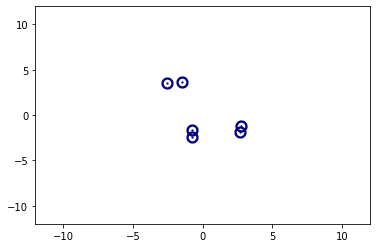

In [7]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances
seed = np.random.RandomState(seed=3)
similarities = euclidean_distances(x_train)
mds = MDS(
    n_components=2,
    max_iter=3000,
    eps=1e-9,
    random_state=seed,
    dissimilarity="precomputed",
    n_jobs=1,
)
# clf = PCA(n_components=2)
# x_pca = clf.fit_transform(x_train)
x_mds = mds.fit(similarities).embedding_
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

plt.scatter(x_mds[:,0],x_mds[:,1],color="navy", s=5, lw=10, label="healthy physical samples")
plt.ylim(-12,12)
plt.xlim(-12,12)

In [8]:
fs = 40 #性能实验采样频率为40Hz
x = x_train #训练集
N = 496 #the number of the synthetic sequences
synthetic_set = FWDBA_aug(x,fs,N) #人造数据集


n=0
[(0, 1.6093697987275952), (1, 2.1582347962368655), (2, 1.9572137025339376), (3, 1.5354674288074222), (4, 0.0), (5, 1.8508218293312568)]
0
1
2
3
4
5
Doing iteration
  0 ...
  1 ...
  2 ...
  3 ...
  4 ...
  5 ...
  6 ...
  7 ...
  8 ...
  9 ...
n=1
[(0, 1.6093697987275952), (1, 2.1582347962368655), (2, 1.9572137025339376), (3, 1.5354674288074222), (4, 0.0), (5, 1.8508218293312568)]
0
1
2
3
4
5
Doing iteration
  0 ...
  1 ...
  2 ...
  3 ...
  4 ...
  5 ...
  6 ...
  7 ...
  8 ...
  9 ...
n=2
[(0, 1.6093697987275952), (1, 2.1582347962368655), (2, 1.9572137025339376), (3, 1.5354674288074222), (4, 0.0), (5, 1.8508218293312568)]
0
1
2
3
4
5
Doing iteration
  0 ...
  1 ...
  2 ...
  3 ...
  4 ...
  5 ...
  6 ...
  7 ...
  8 ...
  9 ...
n=3
[(0, 1.6093697987275952), (1, 2.1582347962368655), (2, 1.9572137025339376), (3, 1.5354674288074222), (4, 0.0), (5, 1.8508218293312568)]
0
1
2
3
4
5
Doing iteration
  0 ...
  1 ...
  2 ...
  3 ...
  4 ...
  5 ...
  6 ...
  7 ...
  8 ...
  9 ...
n=4
[(0,

(-10.0, 10.0)

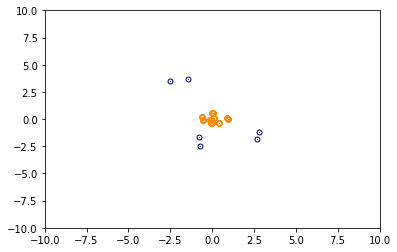

In [9]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances
# clf = PCA(n_components=2)
seed = np.random.RandomState(seed=3)
similarities = euclidean_distances(x_train)
similarities_syn = euclidean_distances(synthetic_set)
mds = MDS(
    n_components=2,
    max_iter=3000,
    eps=1e-9,
    random_state=seed,
    dissimilarity="precomputed",
    n_jobs=1,
)
# x_pca = clf.fit_transform(x_train)
# syn_pca = clf.fit_transform(synthetic_set)
x_mds = mds.fit(similarities).embedding_
syn_mds = mds.fit(similarities_syn).embedding_
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
plt.scatter(x_mds[:,0],x_mds[:,1],color="navy", s=1, lw=5, label="healthy physical samples")
plt.scatter(syn_mds[:,0],syn_mds[:,1],color="darkorange", s=1, lw=5, label="healthy synthetic samples")
plt.ylim(-10,10)
plt.xlim(-10,10)

In [10]:
from scipy.io import savemat
savemat(r'F:\python file\WDBA-digital twin\steering_machine_data_fast.mat',{'synthetic_moment_health':synthetic_set})

In [11]:

# from sklearn.neighbors import KernelDensity  # kernel density estimation
# from sklearn.model_selection import GridSearchCV
# #-------------------------------------------------------------
# route_1_1 = r'F:\文件中转站\Seafile\私人资料库\15所项目\转向机退化与性能试验实验数据2021-02-01\转向机第一次实验数据\转向机第一次性能试验数据\zxj_700_6000_8rpm_1.mat'
# route_1_2 = r'F:\文件中转站\Seafile\私人资料库\15所项目\转向机退化与性能试验实验数据2021-02-01\转向机第一次实验数据\转向机第一次性能试验数据\zxj_700_6000_8rpm_2.mat'

# moment_8rpm_1 = loadmat(route_1_1)['zxj_700_6000_8rpm_1'][:3185,1]
# moment_8rpm_2 = loadmat(route_1_2)['zxj_700_6000_8rpm_2'][:3185,1]

# m_8_h = np.empty((100,500))
# for i in range(50):
#     m_8_h[i,:] = normalize(moment_8rpm_1[50+10*i:550+10*i])
# for i in range(50):
#     m_8_h[i+50,:] = normalize(moment_8rpm_1[1650+10*i:2150+10*i])
# raw_data_np = m_8_h

# verify_dict= loadmat(r'F:\python file\WDBA-digital twin\steering_machine_data.mat')
# v_sequence_set = verify_dict['synthetic_moment_health']
# v_sequence = v_sequence_set[0,:].reshape(1,-1)
# #----------------------begin kde plot-------------------------
# grid_param = {
#     'bandwidth':list(range(1,40))
# }
# kde_grid = GridSearchCV(KernelDensity(),grid_param)
# # for jj in range(40):
# T_a = v_sequence

# df = np.concatenate((np.arange(len(T_a.T)).reshape(1,-1),T_a),axis = 0 )
# df_raw = np.concatenate((np.arange(len(T_a.T)).reshape(1,-1),raw_data_np[0,:].reshape(1,-1)),axis = 0)
# kde = kde_grid.fit(df.T).best_estimator_

# plt.figure()
# plt.subplot(2, 1, 1)
# plt.plot(df[0,:],np.exp(kde.score_samples(df.T)))
# plt.subplot(2, 1, 2)
# plt.plot(df[0,:],np.exp(kde.score_samples(df_raw.T)))

In [12]:
data_dict=loadmat(r'F:\python file\WDBA-digital twin\steering_machine_data_fast.mat')
data_sample = data_dict['synthetic_moment_health']

In [13]:

from scipy.io import loadmat
from scipy.io import savemat
import numpy as np
import torch
import torch.nn as nn
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from scipy.fftpack import fft
import matplotlib.pyplot as plt
scalar=MinMaxScaler()  

In [14]:
# data_dict=loadmat(r'F:\python file\WDBA-digital twin\steering_machine_data_fast.mat')
# data_sample = data_dict['synthetic_moment_health']

# route_1_1 = r'F:\文件中转站\Seafile\私人资料库\15所项目\转向机退化与性能试验实验数据2021-02-01\转向机第一次实验数据\转向机第一次性能试验数据\zxj_700_6000_8rpm_1.mat'
# route_1_2 = r'F:\文件中转站\Seafile\私人资料库\15所项目\转向机退化与性能试验实验数据2021-02-01\转向机第一次实验数据\转向机第一次性能试验数据\zxj_700_6000_8rpm_2.mat'
# route_3
# moment_8rpm_1 = loadmat(route_1_1)['zxj_700_6000_8rpm_1'][:3185,1]
# moment_8rpm_2 = loadmat(route_1_2)['zxj_700_6000_8rpm_2'][:3185,1]

# m_8_h = np.empty((100,1000))
# for i in range(50):
#     m_8_h[i,:] = normalize(moment_8rpm_1[50+10*i:1050+10*i])
# for i in range(50):
#     m_8_h[i+50,:] = normalize(moment_8rpm_1[1650+10*i:2650+10*i])
# raw_data_np = m_8_h

In [15]:
def sample_idx(m,n):
    A=np.random.permutation(m)
    num=int(m/n)
    B=np.empty((num,n))
    for i in range(num):
        B[i,:]=A[n*i:n*(i+1)]
    idx=B.astype(int)
    return num,idx

In [16]:
b_size = 32 # 设定batch_size为32
L = 1440
data_sample_raw = np.concatenate((raw_data_np,synthetic_set),axis = 0)
data_train_raw = torch.tensor(data_sample_raw).T #已经经过标准化处理
data_train = data_train_raw
# ii=0
# for i in range(200):
#     for j in range(int(20480/L)):
#         data_train[:,ii] = normalize(data_train_raw[(j)*L:(j+1)*L,i])
#         ii=ii+1
num_train = 502

In [17]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, L = x.size()  # read in N, C, L
        z = x.view(N, -1)
#        print(C, L)
        return z  # "flatten" the C * L values into a single vector per image

class WDT_discriminator(nn.Module):
    def __init__(self,kernel_num1 = 32,kernel_num2 = 64,kernel_num3 = 128,kernel_num4 = 256,batch_size = 32 ):
        super().__init__()
        self.b_size = batch_size
        self.layers = nn.Sequential(
            nn.Linear(1440,128),
            nn.LeakyReLU(0.01,inplace = False),
            nn.Linear(128,16),
            nn.LeakyReLU(0.01,inplace = False),
            nn.Linear(16,1)
        )
        # self.layer2=nn.Sequential(
        #     nn.Linear(256*11,256),
        #     nn.LeakyReLU(0.01,inplace=True),
        #     nn.Linear(256,1)
        #     # nn.LeakyReLU(0.01,inplace=True),
        #     # nn.Linear(32,1),
        # )
        # self.layers3 = nn.Sequential(
        #     nn.Linear(4096,1280),
        #     nn.LeakyReLU(0.01,inplace=True),
        #     nn.Linear(1280,256),
        #     nn.LeakyReLU(0.01,inplace=True),
        #     # nn.BatchNorm1d(64),
        #     nn.Linear(256,1)
        #     # nn.ReLU()
        # )
    
    def forward(self,x):
        x1=self.layers(x)
        # x2=self.layer2(x1)
        # x3=self.layers3(x)
        return x1
        
# class Deflatten(nn.Module):
#     def forward(self, x):
#         N, L = x.size()  # read in N, C, L
#         z = x.view(N,1,-1)
# #        print(C, L)
#         return z  # "flatten" the C * L values into a single vector per image

class WDT_generator(nn.Module):
    def __init__(self,kernel_num1 = 128,kernel_num2 = 64,kernel_num3 = 32):
        super().__init__()
        self.dense=nn.Sequential(
            nn.Linear(64,512),
            nn.BatchNorm1d(512),
            # nn.LeakyReLU(0.01,inplace=True),
            # nn.Linear(1024,4096),
            nn.LeakyReLU(0.01,inplace=True),
            nn.Linear(512,1440),
            nn.BatchNorm1d(1440),
            nn.Sigmoid()
        )

    def forward(self,x):
        # x1=self.dense(x)
        # x2=x1.view(-1,512,8)
        
        return self.dense(x)

In [18]:
##施加梯度惩罚，来使得训练
def calc_gradient_penalty(netD, real_data, fake_data,BATCH_SIZE,LAMBDA):
    # print "real_data: ", real_data.size(), fake_data.size()
    use_gpu = True
    alpha = torch.rand(BATCH_SIZE,1,1)
    alpha = alpha.expand(real_data.size())
    #alpha = alpha.expand(BATCH_SIZE, real_data.nelement()/BATCH_SIZE).contiguous().view(BATCH_SIZE, 3, 32, 32)
    alpha = alpha.cuda() if use_gpu else alpha

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    
    if use_gpu:
        interpolates = interpolates.cuda()
    interpolates = torch.autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates.to(torch.float32))
    #disc_interpolates = discriminator(interpolates)

    gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda() if use_gpu else torch.ones(
                                  disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty


In [19]:

wdt_discriminator=WDT_discriminator().cuda()
wdt_generator=WDT_generator().cuda()
optimizer_g = torch.optim.Adam(wdt_generator.parameters(),lr=1e-4,betas=(0.5,0.99))
optimizer_d = torch.optim.Adam(wdt_discriminator.parameters(),lr=1e-4,betas=(0.5,0.99))

In [31]:
num_epoch = 100
clip_value = 0.01
n_critic = 5
batches_done=0

#--------------------------
# torch.manual_seed(1)#为CPU设置随机种子
# torch.cuda.manual_seed(1)#为当前GPU设置随机种子
# torch.cuda.manual_seed_all(1)#为所有GPU设置随机种子
#--------------------------
wdt_generator.train()
wdt_discriminator.train()
for i in range(num_epoch):
    num,idx = sample_idx(num_train, b_size)
    for j in range(num):
        z_ = np.random.normal(0,1,(b_size, 64))
        z = torch.tensor(z_).to(torch.float32).cuda()
        # fake_data = wdt_generator(z).detach().view(b_size,1,-1)
        fake_data = wdt_generator(z).detach().view(b_size,1,-1)
        # real_data = data_train[:,idx[j,:].tolist()].view(b_size,1,-1).cuda()
        real_data = data_train[:,idx[j,:].tolist()].view(b_size,1,-1).cuda()
        optimizer_d.zero_grad()
        gradient_penalty =calc_gradient_penalty(wdt_discriminator,real_data,fake_data,b_size,LAMBDA=1).cuda()
        loss_D = -torch.mean(wdt_discriminator(real_data.to(torch.float32))) + torch.mean(wdt_discriminator(fake_data.to(torch.float32))) + gradient_penalty
        # loss_D = -torch.mean(torch.log(wdt_discriminator(real_data.to(torch.float32)))) - torch.mean(torch.log(1-wdt_discriminator(fake_data.to(torch.float32))))
        loss_D.backward()
        optimizer_d.step()
        # for p in wdt_discriminator.parameters():
        #     p.data.clamp_(-clip_value, clip_value)
        if batches_done % n_critic == 0:
            optimizer_g.zero_grad()
            gen_imgs = wdt_generator(z)
            loss_G = -torch.mean(wdt_discriminator(gen_imgs.view(b_size,1,-1).to(torch.float32)))
            # loss_G = -torch.mean(torch.log(wdt_discriminator(gen_imgs.view(b_size,1,-1).to(torch.float32))))
            
            loss_G.backward()
            optimizer_g.step()
            name_G = 'F:/python file/WDBA-digital twin/steering_model_G/G_'+str(batches_done)+'.pth' 
            name_C = 'F:/python file/WDBA-digital twin/steering_model_C/C_'+str(batches_done)+'.pth' 
            torch.save(wdt_generator,name_G)
            torch.save(wdt_discriminator,name_C)
            # print(
            #     "[Epoch %d/%d]   [gradient_penalty %f] [D loss: %f] [G loss: %f]"
            #     % (i, num_epoch ,gradient_penalty.item(), loss_D.item(), loss_G.item())
            # )
            print(
                "[Epoch %d/%d]  [D loss: %f] [G loss: %f]"
                % (i, num_epoch , loss_D.item(), loss_G.item())
            )
            wdt_generator.train()
        batches_done = batches_done+1

[Epoch 0/100]  [D loss: -0.866285] [G loss: -22.029200]
[Epoch 0/100]  [D loss: -0.831383] [G loss: -22.015354]
[Epoch 0/100]  [D loss: -0.831121] [G loss: -22.093370]
[Epoch 1/100]  [D loss: -0.818769] [G loss: -21.904823]
[Epoch 1/100]  [D loss: -0.855789] [G loss: -22.018230]
[Epoch 1/100]  [D loss: -0.851388] [G loss: -22.084057]
[Epoch 2/100]  [D loss: -0.814642] [G loss: -22.000471]
[Epoch 2/100]  [D loss: -0.828404] [G loss: -22.070608]
[Epoch 2/100]  [D loss: -0.808034] [G loss: -21.954418]
[Epoch 3/100]  [D loss: -0.810276] [G loss: -21.906460]
[Epoch 3/100]  [D loss: -0.855710] [G loss: -22.128973]
[Epoch 3/100]  [D loss: -0.810661] [G loss: -21.870140]
[Epoch 4/100]  [D loss: -0.796055] [G loss: -21.974367]
[Epoch 4/100]  [D loss: -0.868349] [G loss: -22.024956]
[Epoch 4/100]  [D loss: -0.805304] [G loss: -21.924522]
[Epoch 5/100]  [D loss: -0.825147] [G loss: -21.804209]
[Epoch 5/100]  [D loss: -0.814363] [G loss: -21.919880]
[Epoch 5/100]  [D loss: -0.820717] [G loss: -22.

In [35]:
dict_1_1 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目\重采样交叉对比分析\转向机退化与性能试验实验数据2021-02-01\转向机第一次实验数据\转向机第一次性能试验数据\zxj_700_6000_8rpm_1.mat')
dict_1_2 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目\重采样交叉对比分析\转向机退化与性能试验实验数据2021-02-01\转向机第一次实验数据\转向机第一次性能试验数据\zxj_700_6000_8rpm_2.mat')

dict_2_1 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目\重采样交叉对比分析\转向机退化与性能试验实验数据2021-02-01\转向机第二次实验数据\转向机第二次性能实验数据\zxj2_700_6000_8rpm_1.mat')
dict_2_2 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目\重采样交叉对比分析\转向机退化与性能试验实验数据2021-02-01\转向机第二次实验数据\转向机第二次性能实验数据\zxj2_700_6000_8rpm_2.mat')
dict_2_3 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目\重采样交叉对比分析\转向机退化与性能试验实验数据2021-02-01\转向机第二次实验数据\转向机第二次性能实验数据\zxj2_700_6000_8rpm_3.mat')

#=================================================================================================================================================================================
# dict_3_1 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目第二阶段\项目第二轮性能实验\第一次性能实验\第二个转向机健康40与4800频率实验数据\系统测量的压力流量转矩\xzxj_xt_700_6000_8rpm_1.mat')
# # dict_3_2 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目\重采样交叉对比分析\转向机退化与性能试验实验数据2021-02-01\转向机第二次实验数据\转向机第二次性能实验数据\zxj2_700_6000_8rpm_2.mat')
# # dict_3_3 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目\重采样交叉对比分析\转向机退化与性能试验实验数据2021-02-01\转向机第二次实验数据\转向机第二次性能实验数据\zxj2_700_6000_8rpm_3.mat')

# dict_4_1 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目第二阶段\项目第二轮性能实验\第二次性能实验\第二个转向机25%退化40与4800频率的实验数据\系统测量性能实验数据\xzxj_xt_700_6000_8rpm_1.mat')
# # dict_4_2 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目\重采样交叉对比分析\转向机退化与性能试验实验数据2021-02-01\转向机第二次实验数据\转向机第二次性能实验数据\zxj2_700_6000_8rpm_2.mat')
# # dict_4_3 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目\重采样交叉对比分析\转向机退化与性能试验实验数据2021-02-01\转向机第二次实验数据\转向机第二次性能实验数据\zxj2_700_6000_8rpm_3.mat')

# dict_5_1 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目第二阶段\项目第二轮性能实验\新转向机有外接性能试验数据50%\xzxj50_xt2_700_6000_8rpm_1.mat')
# # dict_5_2 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目\重采样交叉对比分析\转向机退化与性能试验实验数据2021-02-01\转向机第二次实验数据\转向机第二次性能实验数据\zxj2_700_6000_8rpm_2.mat')
# # dict_5_3 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目\重采样交叉对比分析\转向机退化与性能试验实验数据2021-02-01\转向机第二次实验数据\转向机第二次性能实验数据\zxj2_700_6000_8rpm_3.mat')

# dict_6_1 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目第二阶段\项目第二轮性能实验\75%\xzxj4_xt_700_6000_8rpm_1.mat')
# # dict_6_2 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目\重采样交叉对比分析\转向机退化与性能试验实验数据2021-02-01\转向机第二次实验数据\转向机第二次性能实验数据\zxj2_700_6000_8rpm_2.mat')
# # dict_6_3 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目\重采样交叉对比分析\转向机退化与性能试验实验数据2021-02-01\转向机第二次实验数据\转向机第二次性能实验数据\zxj2_700_6000_8rpm_3.mat')


#=================================================================================================================================================================================

dict_7_1 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目\重采样交叉对比分析\转向机退化与性能试验实验数据2021-02-01\转向机第三次实验数据\第三次性能试验数据\zxj3_700_6000_8rpm_1.mat')
dict_7_2 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目\重采样交叉对比分析\转向机退化与性能试验实验数据2021-02-01\转向机第三次实验数据\第三次性能试验数据\zxj3_700_6000_8rpm_2.mat')
dict_7_3 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目\重采样交叉对比分析\转向机退化与性能试验实验数据2021-02-01\转向机第三次实验数据\第三次性能试验数据\zxj3_700_6000_8rpm_3.mat')

dict_8_1 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目\重采样交叉对比分析\转向机退化与性能试验实验数据2021-02-01\第四次性能实验数据\zxj4_700_6000_8rpm_1.mat')
dict_8_2 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目\重采样交叉对比分析\转向机退化与性能试验实验数据2021-02-01\第四次性能实验数据\zxj4_700_6000_8rpm_2.mat')
dict_8_3 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目\重采样交叉对比分析\转向机退化与性能试验实验数据2021-02-01\第四次性能实验数据\zxj4_700_6000_8rpm_3.mat')
dict_8_4 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目\重采样交叉对比分析\转向机退化与性能试验实验数据2021-02-01\第四次性能实验数据\zxj4_700_6000_8rpm_4.mat')
dict_8_5 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目\重采样交叉对比分析\转向机退化与性能试验实验数据2021-02-01\第四次性能实验数据\zxj4_700_6000_8rpm_5.mat')

dict_9_1 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目\重采样交叉对比分析\转向机退化与性能试验实验数据2021-02-01\第五次性能试验数据\zxj5_700_6000_8rpm_1.mat')
dict_9_2 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目\重采样交叉对比分析\转向机退化与性能试验实验数据2021-02-01\第五次性能试验数据\zxj5_700_6000_8rpm_2.mat')
dict_9_3 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目\重采样交叉对比分析\转向机退化与性能试验实验数据2021-02-01\第五次性能试验数据\zxj5_700_6000_8rpm_3.mat')
dict_9_4 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目\重采样交叉对比分析\转向机退化与性能试验实验数据2021-02-01\第五次性能试验数据\zxj5_700_6000_8rpm_4.mat')
dict_9_5 = loadmat(r'F:\文件中转站\Seafile\私人资料库\15所项目\重采样交叉对比分析\转向机退化与性能试验实验数据2021-02-01\第五次性能试验数据\zxj5_700_6000_8rpm_5.mat')

#===================================================
data_1_1 = dict_1_1['zxj_700_6000_8rpm_1'][:,1]
data_1_2 = dict_1_2['zxj_700_6000_8rpm_2'][:,1]

#===================================================
data_2_1 = dict_2_1['zxj2_700_6000_8rpm_1'][:,1]
#===================================================

# data_3_1 = dict_3_1['xzxj_xt_700_6000_8rpm_1'][:,1]
# data_4_1 = dict_4_1['xzxj_xt_700_6000_8rpm_1'][:,1]
# data_5_1 = dict_5_1['xzxj50_xt2_700_6000_8rpm_1'][:,1]
# data_6_1 = dict_6_1['xzxj4_xt_700_6000_8rpm_1'][:,1]

#===================================================
data_7_1 = dict_7_1['zxj3_700_6000_8rpm_1'][:,1]
data_7_2 = dict_7_2['zxj3_6000_700_8rpm_2'][:,1]
data_8_1 = dict_8_1['zxj4_700_6000_8rpm_1'][:,1]
data_8_2 = dict_8_2['zxj4_700_6000_8rpm_2'][:,1]
data_9_1 = dict_9_1['zxj5_700_6000_8rpm_1'][:,1]
data_9_2 = dict_9_2['zxj5_700_6000_8rpm_2'][:,1]

test_set_1_1 = np.empty((1,1440))
test_set_1_2 = np.empty((1,1440))
for i in range(1):
    test_set_1_1[i,:] = normalize(data_1_1[150:1590])
for i in range(1):
    test_set_1_2[i,:] = normalize(data_1_1[150:1590])
test_set_1 = np.concatenate((test_set_1_1,test_set_1_2),axis = 0)


# test_set_2 = np.empty((50,500))
test_set_2_1 = np.empty((1,1440))
test_set_2_2 = np.empty((1,1440))
for i in range(1):
    test_set_2_1[i,:] = normalize(data_2_1[150:1590])
for i in range(1):
    test_set_2_2[i,:] = normalize(data_2_1[150:1590])
test_set_2 = np.concatenate((test_set_2_1,test_set_2_2),axis = 0)

# test_set_3_1 = np.empty((50,1000))
# test_set_3_2 = np.empty((50,1000))
# test_set_3 = np.empty((100,1000))
# for i in range(50):
#     test_set_3_1[i,:] = normalize(data_3_1[50+10*i:1050+10*i])
# for i in range(50):
#     test_set_3_2[i,:] = normalize(data_3_1[1650+10*i:2650+10*i])
# test_set_3 = np.concatenate((test_set_3_1,test_set_3_2),axis = 0)

# test_set_4_1 = np.empty((50,1000))
# test_set_4_2 = np.empty((50,1000))
# test_set_4 = np.empty((100,1000))
# for i in range(50):
#     test_set_4_1[i,:] = normalize(data_4_1[50+10*i:1050+10*i])
# for i in range(50):
#     test_set_4_2[i,:] = normalize(data_4_1[1650+10*i:2650+10*i])
# test_set_4 = np.concatenate((test_set_4_1,test_set_4_2),axis = 0)

# test_set_5_1 = np.empty((50,1000))
# test_set_5_2 = np.empty((50,1000))
# test_set_5 = np.empty((100,1000))
# for i in range(50):
#     test_set_5_1[i,:] = normalize(data_5_1[50+10*i:1050+10*i])
# for i in range(50):
#     test_set_5_2[i,:] = normalize(data_5_1[1650+10*i:2650+10*i])
# test_set_5 = np.concatenate((test_set_5_1,test_set_5_2),axis = 0)

# test_set_6_1 = np.empty((50,1000))
# test_set_6_2 = np.empty((50,1000))
# test_set_6 = np.empty((100,1000))
# for i in range(50):
#     test_set_6_1[i,:] = normalize(data_6_1[50+10*i:1050+10*i])
# for i in range(50):
#     test_set_6_2[i,:] = normalize(data_6_1[1650+10*i:2650+10*i])
# test_set_6 = np.concatenate((test_set_6_1,test_set_6_2),axis = 0)

test_set_7_1 = np.empty((1,1440))
test_set_7_2 = np.empty((1,1440))
test_set_7 = np.empty((2,1440))
for i in range(1):
    test_set_7_1[i,:] = normalize(data_7_1[150:1590])
for i in range(1):
    test_set_7_2[i,:] = normalize(data_7_2[150:1590])
test_set_7 = np.concatenate((test_set_7_1,test_set_7_2),axis = 0)

test_set_8_1 = np.empty((1,1440))
test_set_8_2 = np.empty((1,1440))
test_set_8 = np.empty((2,1440))
for i in range(1):
    test_set_8_1[i,:] = normalize(data_8_1[150:1590])
for i in range(1):
    test_set_8_2[i,:] = normalize(data_8_1[150:1590])
test_set_8 = np.concatenate((test_set_8_1,test_set_8_2),axis = 0)

test_set_9_1 = np.empty((1,1440))
test_set_9_2 = np.empty((1,1440))
test_set_9 = np.empty((2,1440))
for i in range(1):
    test_set_9_1[i,:] = normalize(data_9_1[150:1590])
for i in range(1):
    test_set_9_2[i,:] = normalize(data_9_1[150:1590])
test_set_9 = np.concatenate((test_set_9_1,test_set_9_2),axis = 0)

# test_set = np.concatenate((test_set_1, test_set_2,test_set_3,test_set_4,test_set_5,test_set_6,test_set_7,test_set_8,test_set_9),axis = 0)

test_set = np.concatenate((test_set_1,test_set_2,test_set_7,test_set_8,test_set_9),axis = 0)

In [33]:
test_set_t = torch.from_numpy(test_set).to(torch.float32).cuda()

{'whiskers': [<matplotlib.lines.Line2D at 0x1d40e6a80d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1d40e6a87f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d40e699d30>,
 'medians': [<matplotlib.lines.Line2D at 0x1d40e6a8f10>,
 'fliers': [<matplotlib.lines.Line2D at 0x1d40e6b02e0>,
 'means': []}

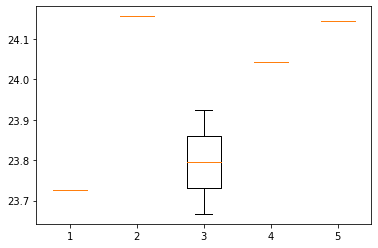

In [34]:
wdt_discriminator.eval()
# HI_t = torch.zeros((1,20)).cuda()
HI_t_1 = wdt_discriminator(test_set_t[0:2,:])
HI_t_2 = wdt_discriminator(test_set_t[2:4,:])
# HI_t_4 = wdt_discriminator(test_set_t[100:150,:])
HI_t_3 = wdt_discriminator(test_set_t[4:6,:])
HI_t_4 = wdt_discriminator(test_set_t[6:8,:])
HI_t_5 = wdt_discriminator(test_set_t[8:10,:])
# HI_t_7 = wdt_discriminator(test_set_t[400:500,:])
# HI_t_8 = wdt_discriminator(test_set_t[500:600,:])
# HI_t_9 = wdt_discriminator(test_set_t[350:400,:])

HI_np_1= HI_t_1.detach().cpu().numpy()
HI_np_2= HI_t_2.detach().cpu().numpy()
HI_np_3= HI_t_3.detach().cpu().numpy()
# HI_np_4= HI_t_4.detach().cpu().numpy()
HI_np_4= HI_t_4.detach().cpu().numpy()
HI_np_5= HI_t_5.detach().cpu().numpy()
# HI_np_7= HI_t_7.detach().cpu().numpy()
# HI_np_8= HI_t_8.detach().cpu().numpy()
# HI_np_9= HI_t_9.detach().cpu().numpy()
HI_np = np.concatenate((HI_np_1,HI_np_2,HI_np_3,HI_np_4,HI_np_5),axis = 1)
plt.boxplot(HI_np)
# HI
# plt.plot(HI.reshape(-1))

In [ ]:
# emission_v = np.array([0.865,0.92,1.2435,1.325,1.34,1.48,1.55,1.51])
emission_v = np.array([0.865,0.92,1.48,1.55,1.51])
plt.plot(emission_v)

In [ ]:
emission_m = np.array([np.median(HI_np_1),np.median(HI_np_2),np.median(HI_np_3),np.median(HI_np_4),np.median(HI_np_5)])
plt.plot(emission_m)